Problem 4: Revisiting Logistic Regression and CIFAR-10.
As before, we’ll throw the kitchen sink of classical ML (i.e. pre-deep learning) on CIFAR-10. Keep
in mind that CIFAR-10 is a few times larger.

• What is the best accuracy you can get on the test data, by tuning Random Forests? What
are the hyperparameters of your best model?

• What is the best accuracy you can get on the test data, by tuning any model including
Gradient boosting? What are the hyperparameters of your best model?


We used XGBoost and Random forest Classifier and optimized the hyperparameters using Bayes Optimization.

** With XGBOOST **

Testing Accuracy= 0.5148

Model=model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=.8015579071911014,
              colsample_bynode=1, colsample_bytree=0.44364889457651413, gamma=0,
              learning_rate=.5313540347564155, max_delta_step=0, max_depth=7,
              min_child_weight=7, missing=None, n_estimators=266, n_jobs=1,
              nthread=None, objective='multi:softmax', random_state=42,
              reg_alpha=0, reg_lambda=352, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


** With Random Forest Classifier **

Testing Accuracy= 0.4436

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                               class_weight=None,
                                               criterion='gini', max_depth=18,
                                               max_features=24,
                                               max_leaf_nodes=None,
                                               max_samples=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=...
                                               n_estimators=100, n_jobs=None,
                                               oob_score=False,
                                               random_state=None, verbose=0,
                                               warm_start=False)




In [0]:
import sklearn.datasets
Data=sklearn.datasets.fetch_openml("CIFAR_10_small")
import numpy as np
import matplotlib.pyplot as plt
Im_data=Data["data"]
Y=Data["target"]

16218
(20000, 32, 32, 3)


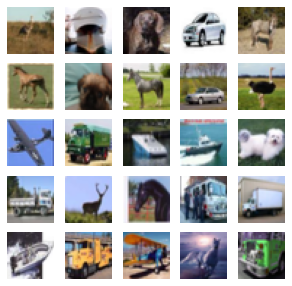

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

#f = open('data/cifar10/cifar-10-batches-py/data_batch_1', 'rb')
#datadict = cPickle.load(f,encoding='latin1')
#f.close()
X = Im_data 
Y = Data['target']
X = X.reshape(20000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
Y = np.array(Y)

#Visualizing CIFAR 10
fig, axes1 = plt.subplots(5,5,figsize=(5,5))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X[i:i+1][0])
print(i)
print(X.shape)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Im_data, Y, test_size=0.25, random_state=42)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from xgboost import XGBClassifier, plot_tree, plot_importance
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
import itertools

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, roc_auc_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#import lightgbm as lgb

In [0]:
pip install scikit-optimize

In [0]:
import xgboost as xgb
#import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

# SETTINGS - CHANGE THESE TO GET SOMETHING MEANINGFUL
ITERATIONS = 50 # 1000
TRAINING_SIZE = 100000 # 20000000
TEST_SIZE = 25000


# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = 1,
        objective = "multi:softmax",
        eval_metric = 'merror',
        silent=1,
        tree_method='approx',
        num_class=10
    ),
    search_spaces = {
        'learning_rate': (0.01,1),
        'min_child_weight': (1,10),
        'max_depth': np.arange(4,15),
        #'max_delta_step': np.arange(1,10),
        #'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01,1),
        'colsample_bylevel': (0.01,1),
        'reg_lambda': (1, 1000, 'log-uniform'),
        #'reg_alpha': (1, 1.0, 'log-uniform'),
        #'gamma': (0,1),
        #'min_child_weight': (1, 10),
        'n_estimators': (100,500),
         #'max_features': np.arange(1,13),
         #'min_samples_split':np.arange(1,10),
        #'scale_pos_weight': (1, 200, 'uniform')
    }, 
    scoring = 'accuracy',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    #n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [0]:
bayes_cv_tuner.fit(X_train,Y_train,callback=status_print)

In [0]:
model=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=.8015579071911014,
              colsample_bynode=1, colsample_bytree=0.44364889457651413, gamma=0,
              learning_rate=.5313540347564155, max_delta_step=0, max_depth=7,
              min_child_weight=7, missing=None, n_estimators=266, n_jobs=1,
              nthread=None, objective='multi:softmax', random_state=42,
              reg_alpha=0, reg_lambda=352, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [0]:
model.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.8015579071911014, colsample_bynode=1,
              colsample_bytree=0.44364889457651413, gamma=0,
              learning_rate=0.5313540347564155, max_delta_step=0, max_depth=7,
              min_child_weight=7, missing=None, n_estimators=266, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=352, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
Y_pred=model.predict(X_test)

In [0]:
Test_Error=accuracy_score(Y_test,Y_pred)

In [0]:
Test_Error

0.5148

In [0]:
def Avg_train_score(model,x,y,cv):
  score=cross_validate(model,x,y,scoring="accuracy", cv=cv)
  return(score["test_score"].mean())

In [0]:
Avg_training_score=Avg_train_score(model,X_train,Y_train,7)

In [0]:
Avg_training_score

0.5050001335111739

In [0]:
estimator = RandomForestClassifier()
search_spaces = {
    'bootstrap': [True, False],
    'max_depth': (3, 20),
    'max_features': (3,24),
    'min_samples_leaf': (1, 4),
    'min_samples_split': (1, 10),
    'n_estimators': (50, 200)
}

bayes_rf = bayesTuner(estimator, search_spaces, trainX, trainY)

In [0]:
import xgboost as xgb
#import lightgbm as lgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

# SETTINGS - CHANGE THESE TO GET SOMETHING MEANINGFUL
ITERATIONS = 50 # 1000
TRAINING_SIZE = 100000 # 20000000
TEST_SIZE = 25000


# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = RandomForestClassifier(
    ),
    search_spaces = {
    'bootstrap': [True, False],
    'max_depth': (3, 20),
    'max_features': (3,24),
    #'min_samples_leaf': (1, 4),
    #'min_samples_split': (1, 10),
    #'n_estimators': (50, 200)
    }, 
    scoring = 'accuracy',
    cv = StratifiedKFold(
        n_splits=3,
        shuffle=True,
        random_state=42
    ),
    #n_jobs = 3,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest Accuracy: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [0]:
bayes_cv_tuner.fit(X_train,Y_train,callback=status_print)

Model #1
Best Accuracy: 0.4061
Best params: OrderedDict([('bootstrap', True), ('max_depth', 15), ('max_features', 23)])

Model #2
Best Accuracy: 0.4191
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 9)])

Model #3
Best Accuracy: 0.4191
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 9)])

Model #4
Best Accuracy: 0.4191
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 9)])

Model #5
Best Accuracy: 0.4191
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 9)])

Model #6
Best Accuracy: 0.4191
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 9)])

Model #7
Best Accuracy: 0.4191
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 9)])

Model #8
Best Accuracy: 0.4237
Best params: OrderedDict([('bootstrap', False), ('max_depth', 19), ('max_features', 13)])

Model #9
Best Accuracy: 0.4237


/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #12
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #13
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #14
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #15
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #16
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #17
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #18
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #19
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #20
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #21
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #22
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #23
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #24
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #25
Best Accuracy: 0.4302
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #26
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #27
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #28
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #29
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #30
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #31
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #32
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #33
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #34
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #35
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #36
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #37
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #38
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])

Model #39
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #40
Best Accuracy: 0.4309
Best params: OrderedDict([('bootstrap', False), ('max_depth', 20), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #41
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #42
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #43
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #44
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])

Model #45
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #46
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])

Model #47
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #48
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #49
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])



/Users/harshut/opt/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model #50
Best Accuracy: 0.4314
Best params: OrderedDict([('bootstrap', False), ('max_depth', 18), ('max_features', 24)])



BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
              error_score='raise',
              estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                               class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               max_samples=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=...
                                               n_estimators=100, n_jobs=None,
                                               oob_score=False,
                                      

In [0]:
best=bayes_cv_tuner.best_params_

In [0]:
model1=RandomForestClassifier(**best)

In [0]:
Test_Error=(accuracy_score(Y_test,bayes_cv_tuner.predict(X_test)))

In [0]:
Test_Error

0.4436